In [2]:
import tensorflow as tf
import numpy as np
from sklearn.datasets import make_blobs, make_circles
import matplotlib.pyplot as plt

In [12]:
DATA_TYPE = "blobs"
if DATA_TYPE == "circle":
    K = 2
    data, features = make_circles(n_samples=200, shuffle=True, noise=0.01, factor=0.4)
else:
    K = 4
    centers = [(-2, -2), (-2, 1.5), (1.5, -2), (2, 1.5)]
    data, features = make_blobs(n_samples=200, 
                                centers=centers, 
                                n_features=2, 
                                cluster_std=0.8, 
                                shuffle=False,
                                random_state=42)

points = tf.Variable(data)
N = points.shape[0].value
cluster_assignments = tf.Variable(tf.zeros([N], dtype=tf.int64))
centroids = tf.Variable(tf.slice(points.initialized_value(), [0, 0], [K, 2]))

sess = tf.Session()
sess.run(tf.global_variables_initializer())

tmp_centroids = tf.tile(centroids, [N, 1])  # N * K, 2
tmp_points = tf.tile(points, [1, K])  # N, (K * 2)
rep_centroids = tf.reshape(tmp_centroids, [N, K, 2])
rep_points = tf.reshape(tmp_points, [N, K, 2])

sum_squares = tf.reduce_sum(tf.square(rep_points - rep_centroids), axis=2)
new_assignments = tf.argmin(sum_squares, axis=1)
did_assignments_change = tf.reduce_any(tf.not_equal(cluster_assignments, new_assignments))
## 给定簇标注，计算簇心（所属簇点集的平均）
def bucket_mean(data, bucket_ids, num_buckets):
    total = tf.unsorted_segment_sum(data, bucket_ids, num_buckets)
    count = tf.unsorted_segment_sum(tf.ones_like(data), bucket_ids, num_buckets)
    return total / count
new_centroids = bucket_mean(points, new_assignments, K)
with tf.control_dependencies([did_assignments_change]):
    do_updates = tf.group(centroids.assign(new_centroids),
                          cluster_assignments.assign(new_assignments))


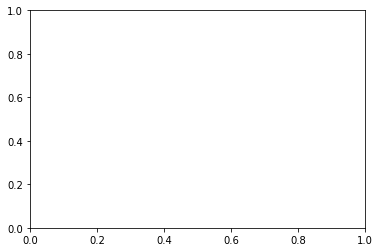

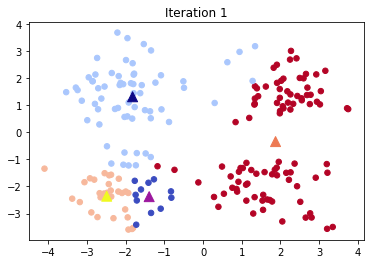

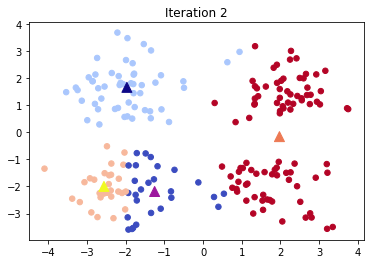

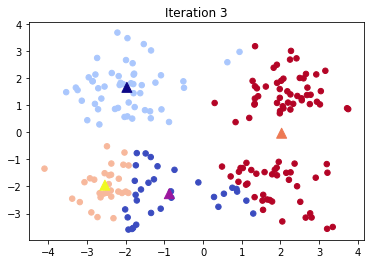

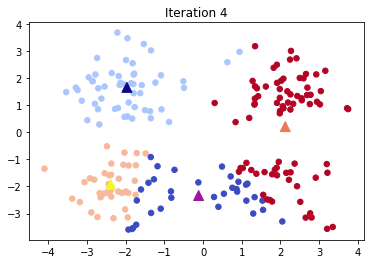

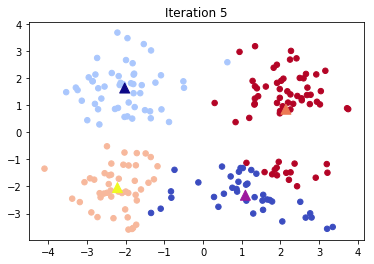

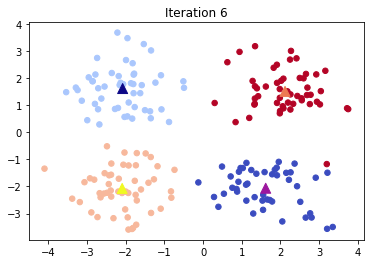

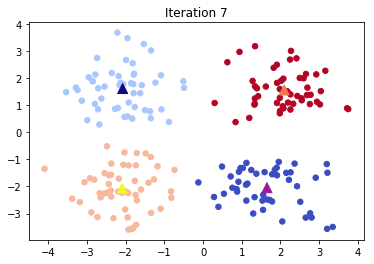

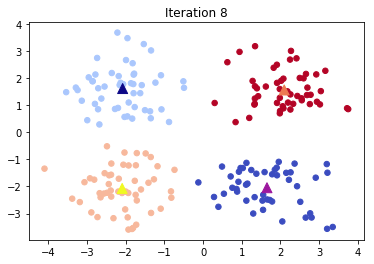

In [13]:
changed = True
iters = 0
MAX_ITERS = 100
path = "/Users/lixing/jupyter/Build ML Projects with TF/Chap02_fig_save/"
fig, ax = plt.subplots()
if (DATA_TYPE == "blobs"):
    color_indexes = [2, 1, 4, 3]
else:
    color_indexes = [2, 1]
while changed and iters < MAX_ITERS:
    fig, ax = plt.subplots()
    iters += 1
    [changed, _] = sess.run([did_assignments_change, do_updates])
    [centers, assignments] = sess.run([centroids, cluster_assignments])
    data = sess.run(points)
    ax.scatter(data[:, 0], 
               data[:, 1], 
               marker="o", 
               s=30, 
               c=assignments, 
               cmap=plt.cm.coolwarm)
    ax.scatter(centers[:, 0], 
               centers[:, 1], 
               marker="^", 
               s=100, 
               c=color_indexes, 
               cmap=plt.cm.plasma)
    
    ax.set_title("Iteration " + str(iters))
    plt.savefig(path + "KMeans" + str(iters) + ".png")